In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rebound as rb
import reboundx as rx

In [3]:
tup_num = 7
e_b = np.linspace(0, 0.7, tup_num)
a_p = np.linspace(1, 5, tup_num)

Np = 4

Qex = []
for x in range(4,7):
    Q = 10**x
    Qex.append(Q)

tup_list = []

for Q in Qex:
    for e in e_b:
        for a in a_p:
            tup_list.append((Q,e,a,Np))

Ne = len(e_b)
Na = len(a_p)
Nq = len(Qex)

In [13]:
def survival(initial):    
    (Q, eb, ap, Np) = initial

    sim = rb.Simulation()
    sim.integrator = "whfast"
    
    mu = 0.5
    m1 = 1
    m2 = abs((m1*mu)/(1-mu))

    sim.add(m=m1, hash="Binary 1")
    sim.add(m=m2, a=1, e= eb, hash="Binary 2")
    
    #initializing Np massless planets
    
    for p in range(Np):
        f_plan = np.random.rand()*2*np.pi
        sim.add(m=0, a= ap, e=0, f= f_plan)
    
    #array to keep track of survival time
    sim.move_to_com()
    
    # Adding Tidal Elements
    rebx = rx.Extras(sim)
    tides = rebx.load_force("tides_constant_time_lag")
    rebx.add_force(tides)
    
    ps = sim.particles
    
    k2 = ps[0].params["tctl_k1"] = 0.035
    nb = ps[1].n
        
    ps[0].params["tctl_tau"] = 3/(2*Q*k2*nb)
    tau = ps[0].params["tctl_tau"]
    
    #integrate
    N_times = int(100)
    N_orbit = (1e4)*2*np.pi
    times = np.linspace(0,N_orbit,N_times)
    surv = np.zeros(Np)
    
    for i, time in enumerate(times):
        
        nb = ps[1].n
        r_eb = ps[1].e
        
        N_re = (1+(15./2.)*r_eb**2+(45./8.)*r_eb**4+(5./16.)*r_eb**6)/(1-r_eb**2)**6
        Omega_re = (1+3*r_eb**2+(3./8.)*r_eb**4)/(1-r_eb**2)**(9./2.)
        ps[0].params["Omega"] = N_re/Omega_re*nb
        
        sim.integrate(time, exact_finish_time=0)
            
        for num in reversed(range(2, sim.N)):
            p = sim.particles[num]

            if (p.x**2 + p.y**2) > (100)**2:
                surv[num-2] = time
                print(f'removing planet {num}')
                sim.remove(num)

            if sim.N==2:
                break
    surv[(surv==0)] = time
    
    print(f'simulation finished, {len(sim.particles)-2} planets remaining')
    return np.mean(surv) 

In [14]:
%%time
pool = rb.InterruptiblePool(processes=16)
mapping = pool.map(func= survival, iterable= tup_list)

removing planet 5
removing planet 3
removing planet 5
removing planet 4
removing planet 3
removing planet 2
removing planet 5
removing planet 4
removing planet 3
removing planet 2
removing planet 5
removing planet 3
removing planet 2
removing planet 5
removing planet 4
removing planet 3
removing planet 2
removing planet 5
removing planet 4
removing planet 3
removing planet 2
removing planet 5
removing planet 4
removing planet 3
removing planet 2
removing planet 3
removing planet 2
removing planet 5
removing planet 4
removing planet 3
removing planet 2
removing planet 2
removing planet 5
removing planet 3
removing planet 2
removing planet 2
simulation finished, 0 planets remaining
removing planet 5
removing planet 4
removing planet 3
removing planet 2
simulation finished, 0 planets remaining
removing planet 5
removing planet 4
removing planet 3
removing planet 2
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
sim

removing planet 4
removing planet 3
removing planet 2
simulation finished, 4 planets remaining
removing planet 2
simulation finished, 4 planets remaining
simulation finished, 4 planets remaining
removing planet 5
removing planet 4
removing planet 3
removing planet 2
simulation finished, 4 planets remaining
simulation finished, 0 planets remaining
removing planet 5
removing planet 4
removing planet 3
removing planet 2
simulation finished, 4 planets remaining
removing planet 5
removing planet 4
removing planet 2
removing planet 2
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
removing planet 2
simulation finished, 0 planets remaining
removing planet 3
removing planet 5
removing planet 4
removing planet 3
removing planet 2
removing planet 3
simulation finished, 0 planets remaining
removing planet 5
removing planet 3
removing planet 2
removing planet 2
simulation finished, 1 planets remaining
simulation finished, 4 planets remaining
simulation finished, 4

In [ ]:
# testing for all surv times

In [127]:
1e4

10000.0

In [ ]:
#file = open("SUNNY_map_tup25plan15_mu0.05_0.5.bin", "r")
#reading = file.readlines()

#newlist = []
#for line in reading:
#    stripped = line.rstrip("\n")
#    newlist.append(stripped)
#file.close()
#
#times = np.array(newlist).astype(float)
#print(times)

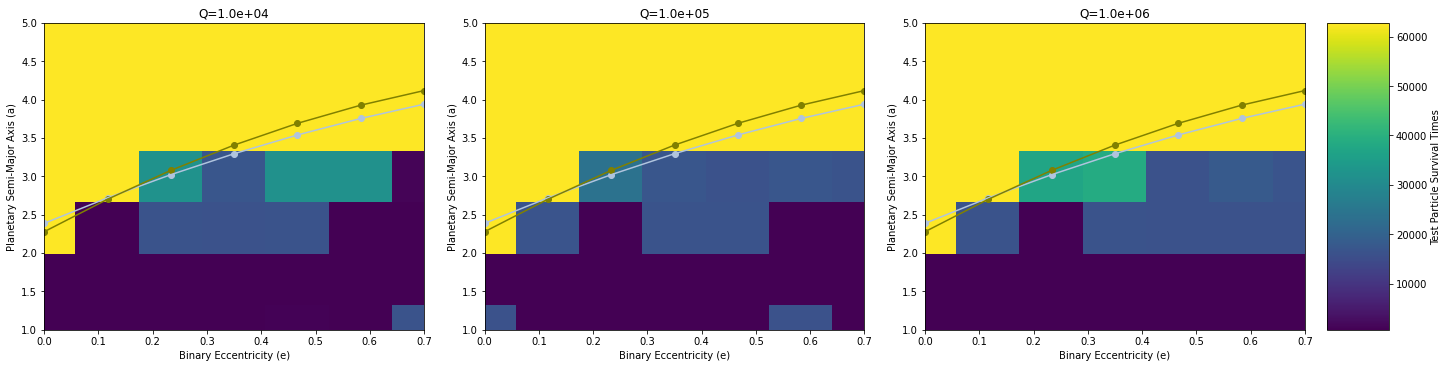

In [29]:
fig, ax = plt.subplots(1, Nq, figsize=(20,5), constrained_layout=True)
ax = ax.ravel()

SurvTimeAll = np.reshape(mapping, [Nq,Ne,Na])
       
SurvTimeArr = [SurvTimeAll[i,:,:] for i in range(Nq)]

for i in range(Nq):
    pcm = ax[i].pcolormesh(e_b, a_p, SurvTimeArr[i].T, shading='auto')
    
    a_b = 2.278 + 3.824*e_b - 1.71*(e_b**2)
    a_c = 1.6 + 5.1*e_b + (- 2.22*(e_b**2)) + 4.12*0.5 + (- 4.27*e_b*0.5) + (- 5.09*(0.5**2)) + 4.61*(e_b**2)*(0.5**2)
    
    ax[i].plot(e_b, a_c, color='lightsteelblue')
    ax[i].scatter(e_b, a_c, color='lightsteelblue')

    ax[i].plot(e_b, a_b, color='olive')
    ax[i].scatter(e_b, a_b, color='olive')
    
    ax[i].set_title('Q={:.1e}'.format(Qex[i]))
    ax[i].set_xlabel('Binary Eccentricity (e)')
    ax[i].set_ylabel('Planetary Semi-Major Axis (a)')
    ax[i].set_xlim(0.0,0.7)
    ax[i].set_ylim(1,5)

plt.colorbar(pcm, location='right',label='Test Particle Survival Times') 

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(10,20), constrained_layout=True)
ax = ax.ravel()

SurvTimeAll = np.reshape(times, [Nm,Ne,Na])
       
SurvTimeArr = [SurvTimeAll[i,:,:] for i in range(Nm)]


for i in range(Nm):
    pcm = ax[i].pcolormesh(e_b, a_p, SurvTimeArr[i].T, shading='auto')
    
    a_b = 2.278 + 3.824*e_b - 1.71*(e_b**2)
    a_c = 1.6 + 5.1*e_b + (- 2.22*(e_b**2)) + 4.12*mass[i] + (- 4.27*e_b*mass[i]) + (- 5.09*(mass[i]**2)) + 4.61*(e_b**2)*(mass[i]**2)
    
    ax[i].plot(e_b, a_c, color='lightsteelblue')
    ax[i].scatter(e_b, a_c, color='lightsteelblue')

    ax[i].plot(e_b, a_b, color='olive')
    ax[i].scatter(e_b, a_b, color='olive')
    
    ax[i].set_title(r'mu={:.3}'.format(mass[i]))

#plt.title('Mean Survival Times with')
    ax[i].set_xlabel('Binary Eccentricity (e)')
    ax[i].set_ylabel('Planetary Semi-Major Axis (a)')
    ax[i].set_xlim(0.0,0.7)
    ax[i].set_ylim(1,5)

plt.colorbar(pcm, location='right',label='Test Particle Survival Times') #ax-ax

In [174]:
sa1 = rb.SimulationArchive('KCeb0.583_ap5.000_Np5.0_tup7.0_tau0.0030.bin')
print("Number of snapshots: %d" % len(sa1))
print(sa1[0].particles[1].e)
# figure out how to access the Hash names, may be useful 

Number of snapshots: 6284
0.5833333333333336


In [192]:
# Functions to Plot Evolution of Binary: Eccentricity and Semi-Major Axis
# only actually need to plot these values based on data from second binary as the primary is the center
# of the simulation

def binary_ecc(archive):
    sim_arc = rb.SimulationArchive(archive)
    
    x_arr = []
    y_arr = []
    
    for snap in range(len(sim_arc)): 
        base = sim_arc[snap].particles[1]
        orb_element = base.e
        time = (sim_arc[snap].t)/1e4
            
        #if orb_element not in y_arr:
        y_arr.append(orb_element)
        x_arr.append(time)
        
    print("Eccentricity Values", y_arr)
    
    fig = plt.figure(figsize=(50,10))
    #plt.ylim([0.3, 1.])
    plt.xlabel("Orbit Number", fontsize=35)
    plt.ylabel("Binary Eccentricity", fontsize=35)
    plt.xticks(fontsize= 35)
    plt.yticks(fontsize= 35)
    plt.plot(x_arr,y_arr, color='green')
    #plt.scatter(x_arr,y_arr, color='green') #, marker=",") #s=2

Eccentricity Values [0.3500000000000002, 0.35000000000000425, 0.35000000000001646, 0.3500000000000165, 0.35000000000001963, 0.35000000000001585, 0.3500000000000271, 0.3500000000000426, 0.35000000000005016, 0.3500000000000518, 0.3500000000000552, 0.35000000000004616, 0.3500000000000492, 0.3500000000000425, 0.3500000000000422, 0.3500000000000446, 0.35000000000004755, 0.3500000000000493, 0.3500000000000492, 0.3500000000000492, 0.3500000000000442, 0.35000000000004106, 0.35000000000003756, 0.35000000000002573, 0.3500000000000264, 0.3500000000000434, 0.35000000000005654, 0.350000000000055, 0.3500000000000591, 0.3500000000000659, 0.3500000000000783, 0.35000000000008225, 0.35000000000006226, 0.35000000000007203, 0.350000000000061, 0.35000000000006076, 0.3500000000000687, 0.3500000000000754, 0.3500000000000764, 0.35000000000008485, 0.3500000000000887, 0.35000000000008824, 0.35000000000009174, 0.35000000000008863, 0.35000000000009956, 0.35000000000010656, 0.35000000000010345, 0.3500000000001039,

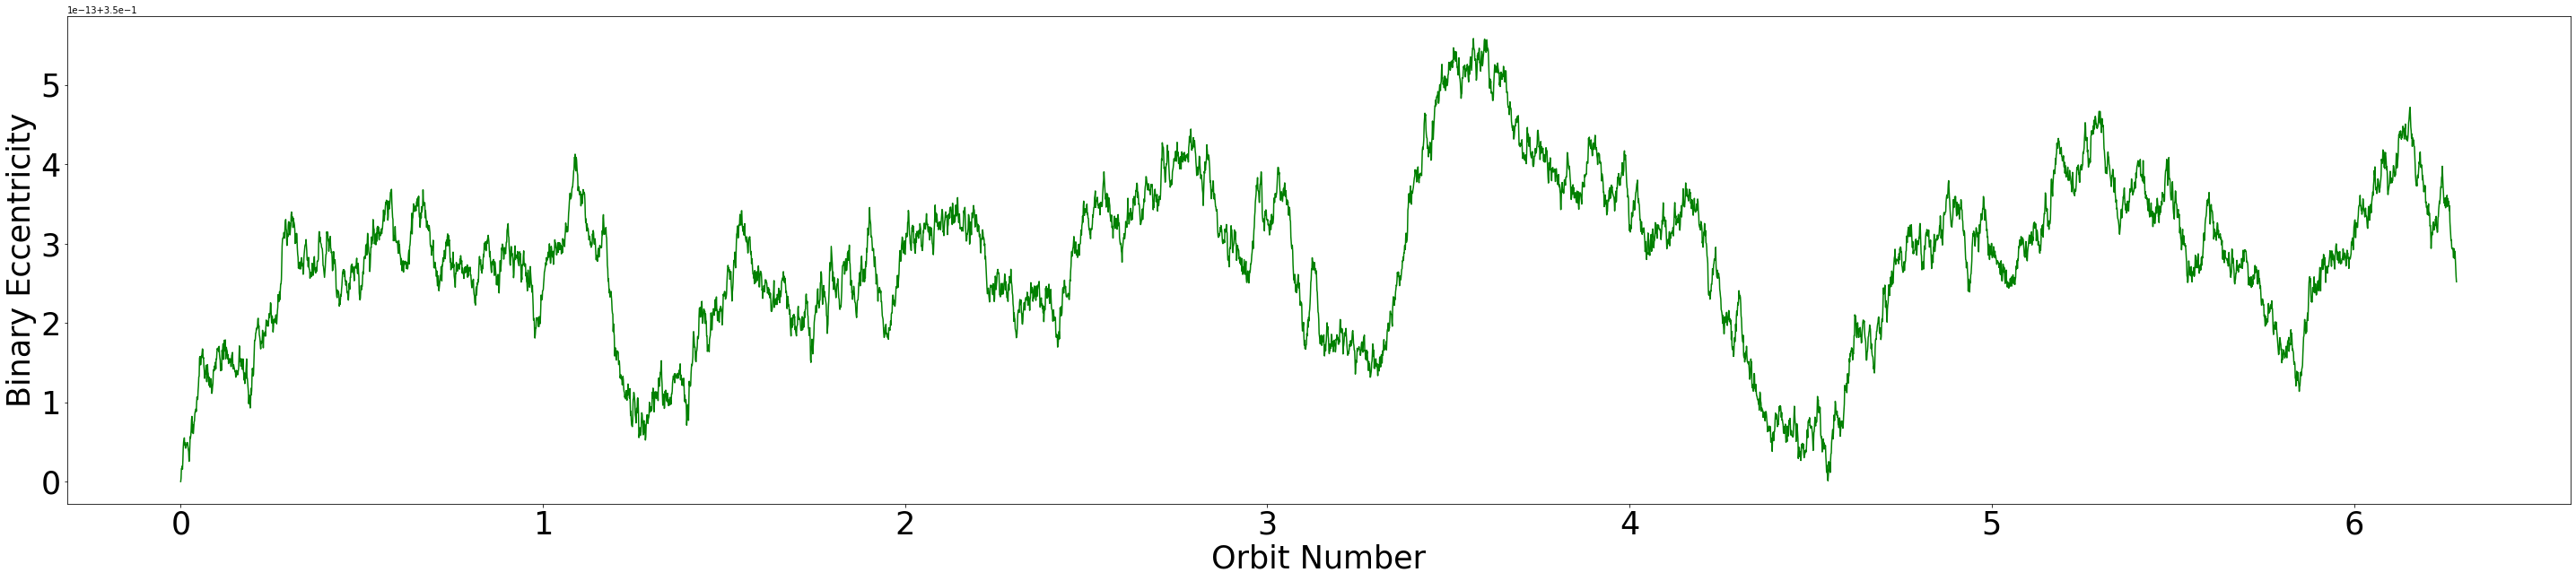

In [193]:
binary_ecc("KCeb0.350_ap5.000_Np5.0_tup7.0_tau0.0030.bin")

Eccentricity Values [0.5833333333333336, 0.583333333333344, 0.5833333333333393, 0.5833333333333393, 0.5833333333333232, 0.5833333333333311, 0.5833333333333361, 0.5833333333333364, 0.5833333333333345, 0.5833333333333326, 0.583333333333324, 0.5833333333333257, 0.5833333333333294, 0.5833333333333361, 0.5833333333333316, 0.5833333333333296, 0.583333333333338, 0.583333333333347, 0.5833333333333457, 0.5833333333333448, 0.5833333333333398, 0.583333333333341, 0.5833333333333418, 0.5833333333333328, 0.5833333333333265, 0.5833333333333233, 0.583333333333315, 0.5833333333333222, 0.5833333333333286, 0.5833333333333255, 0.5833333333333175, 0.5833333333333044, 0.5833333333332988, 0.583333333333302, 0.5833333333333038, 0.5833333333332934, 0.5833333333332925, 0.583333333333302, 0.5833333333333124, 0.5833333333333097, 0.5833333333333118, 0.5833333333333106, 0.583333333333315, 0.5833333333333102, 0.5833333333333062, 0.5833333333333127, 0.5833333333333273, 0.5833333333333222, 0.5833333333333202, 0.583333

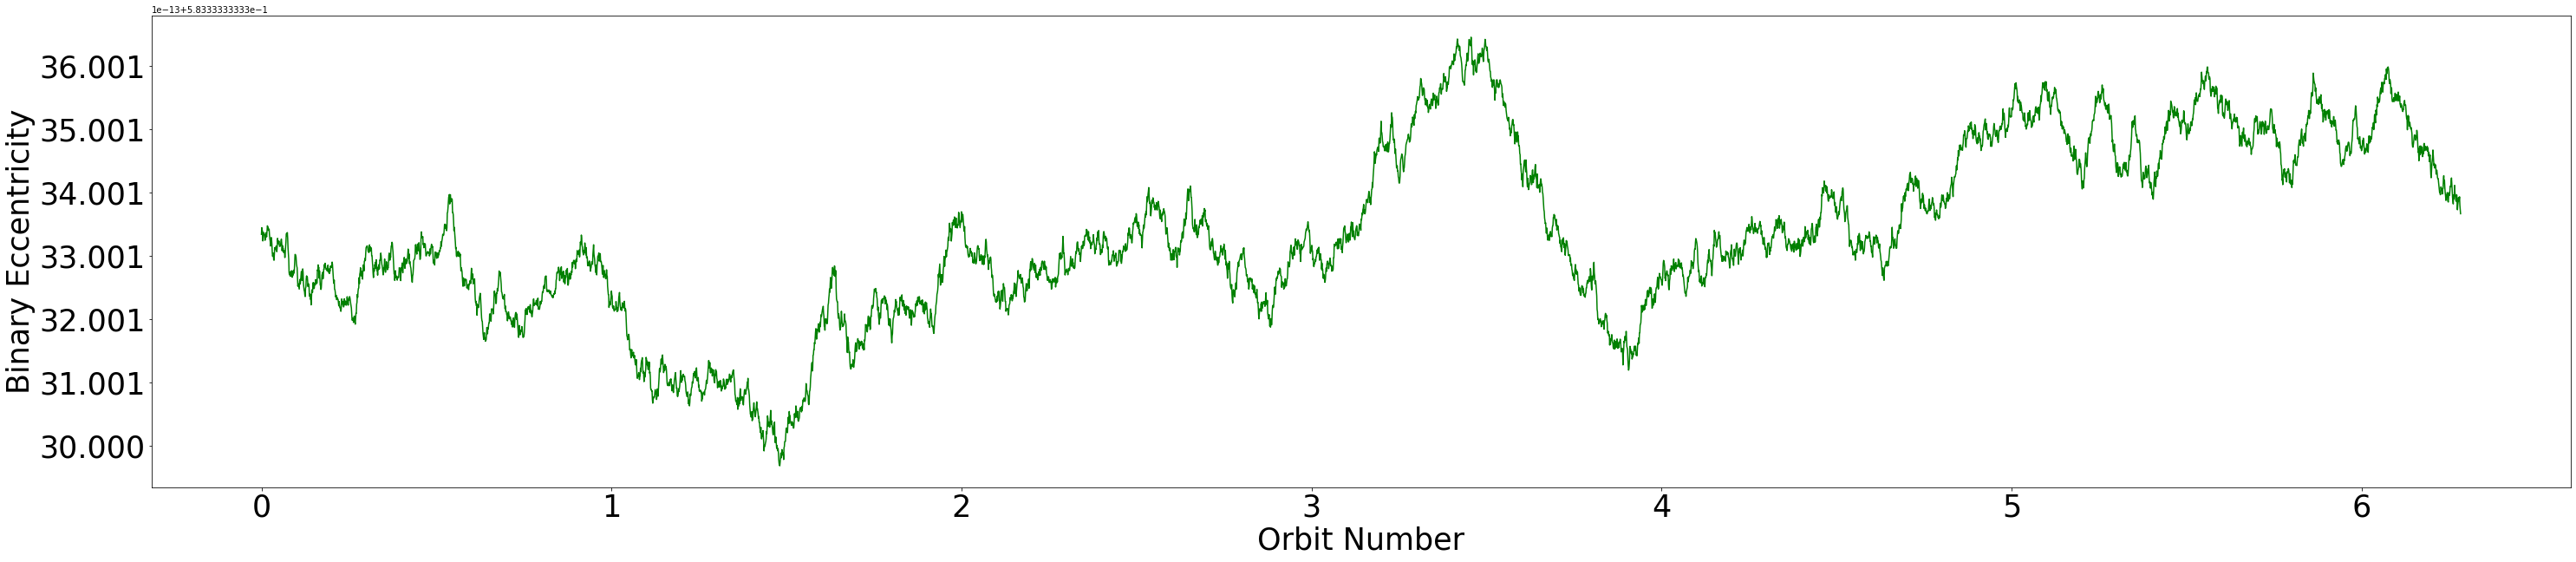

In [194]:
binary_ecc("KCeb0.583_ap5.000_Np5.0_tup7.0_tau0.0030.bin")

In [195]:
# Functions to Plot Evolution of Binary: Eccentricity and Semi-Major Axis
# only actually need to plot these values based on data from second binary as the primary is the center
# of the simulation

def binary_semi(archive):
    sim_arc = rb.SimulationArchive(archive)
    
    x_arr = []
    y_arr = []
    
    for snap in range(len(sim_arc)): 
        base = sim_arc[snap].particles[1]
        orb_element = base.a
        time = (sim_arc[snap].t)/1e4
        
        y_arr.append(orb_element)
        x_arr.append(time)
    
    print("Semi-Major Axis Values", y_arr)
    fig = plt.figure(figsize=(50,10))
    #plt.ylim([0.5, 2.])
    plt.xlabel("Orbit Number", fontsize=35)
    plt.ylabel("Binary Semi-Major Axis", fontsize=35)
    plt.xticks(fontsize= 35)
    plt.yticks(fontsize= 35)
    plt.plot(x_arr,y_arr, color='green')

Semi-Major Axis Values [1.0000000000000004, 1.0000000000000155, 1.0000000000000093, 1.0000000000000193, 1.0000000000000249, 1.0000000000000135, 1.000000000000045, 1.0000000000000682, 1.00000000000008, 1.0000000000000828, 1.0000000000000846, 1.0000000000000862, 1.00000000000008, 1.0000000000000633, 1.0000000000000526, 1.000000000000045, 1.000000000000072, 1.0000000000000957, 1.00000000000008, 1.0000000000000913, 1.000000000000083, 1.0000000000000602, 1.0000000000000795, 1.0000000000000926, 1.0000000000001088, 1.000000000000129, 1.000000000000097, 1.000000000000111, 1.0000000000001208, 1.000000000000126, 1.0000000000001326, 1.0000000000001135, 1.00000000000008, 1.0000000000000933, 1.0000000000000853, 1.0000000000000902, 1.0000000000001004, 1.000000000000088, 1.0000000000000886, 1.0000000000000786, 1.0000000000000644, 1.000000000000077, 1.000000000000089, 1.0000000000000693, 1.000000000000079, 1.0000000000000897, 1.000000000000106, 1.0000000000001206, 1.0000000000001106, 1.000000000000127

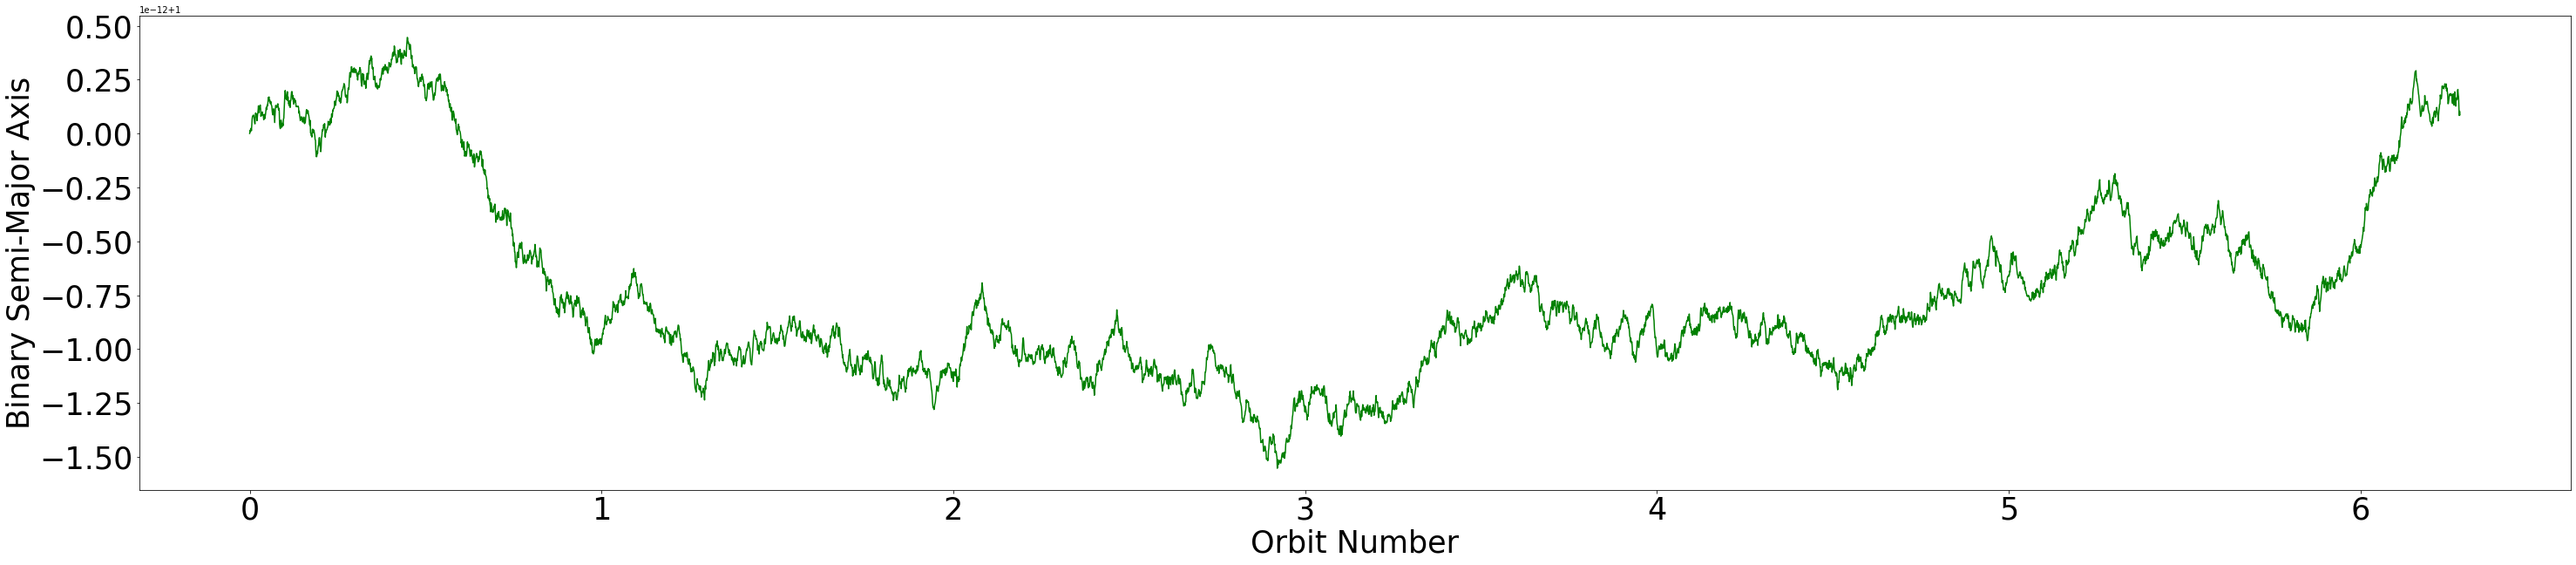

In [196]:
binary_semi("KCeb0.350_ap5.000_Np5.0_tup7.0_tau0.0030.bin")

Semi-Major Axis Values [1.0000000000000009, 1.000000000000007, 0.9999999999999902, 0.9999999999999705, 0.9999999999999449, 0.9999999999999449, 0.9999999999999747, 0.9999999999999789, 0.9999999999999569, 0.9999999999999469, 0.9999999999999221, 0.9999999999999416, 0.9999999999999103, 0.9999999999999527, 0.9999999999999496, 0.9999999999999565, 0.999999999999988, 0.99999999999998, 0.99999999999997, 0.9999999999999558, 0.9999999999999782, 0.9999999999999614, 0.9999999999999654, 0.9999999999999496, 0.9999999999999476, 0.9999999999999707, 0.9999999999999623, 0.9999999999999618, 0.9999999999999791, 0.9999999999999774, 0.999999999999964, 0.99999999999996, 0.9999999999999662, 0.999999999999988, 0.9999999999999933, 0.9999999999999747, 0.9999999999999742, 1.0000000000000215, 1.000000000000042, 1.0000000000000662, 1.000000000000087, 1.0000000000001095, 1.000000000000145, 1.0000000000001297, 1.0000000000001061, 1.0000000000000975, 1.0000000000000906, 1.000000000000068, 1.0000000000000444, 1.00000000

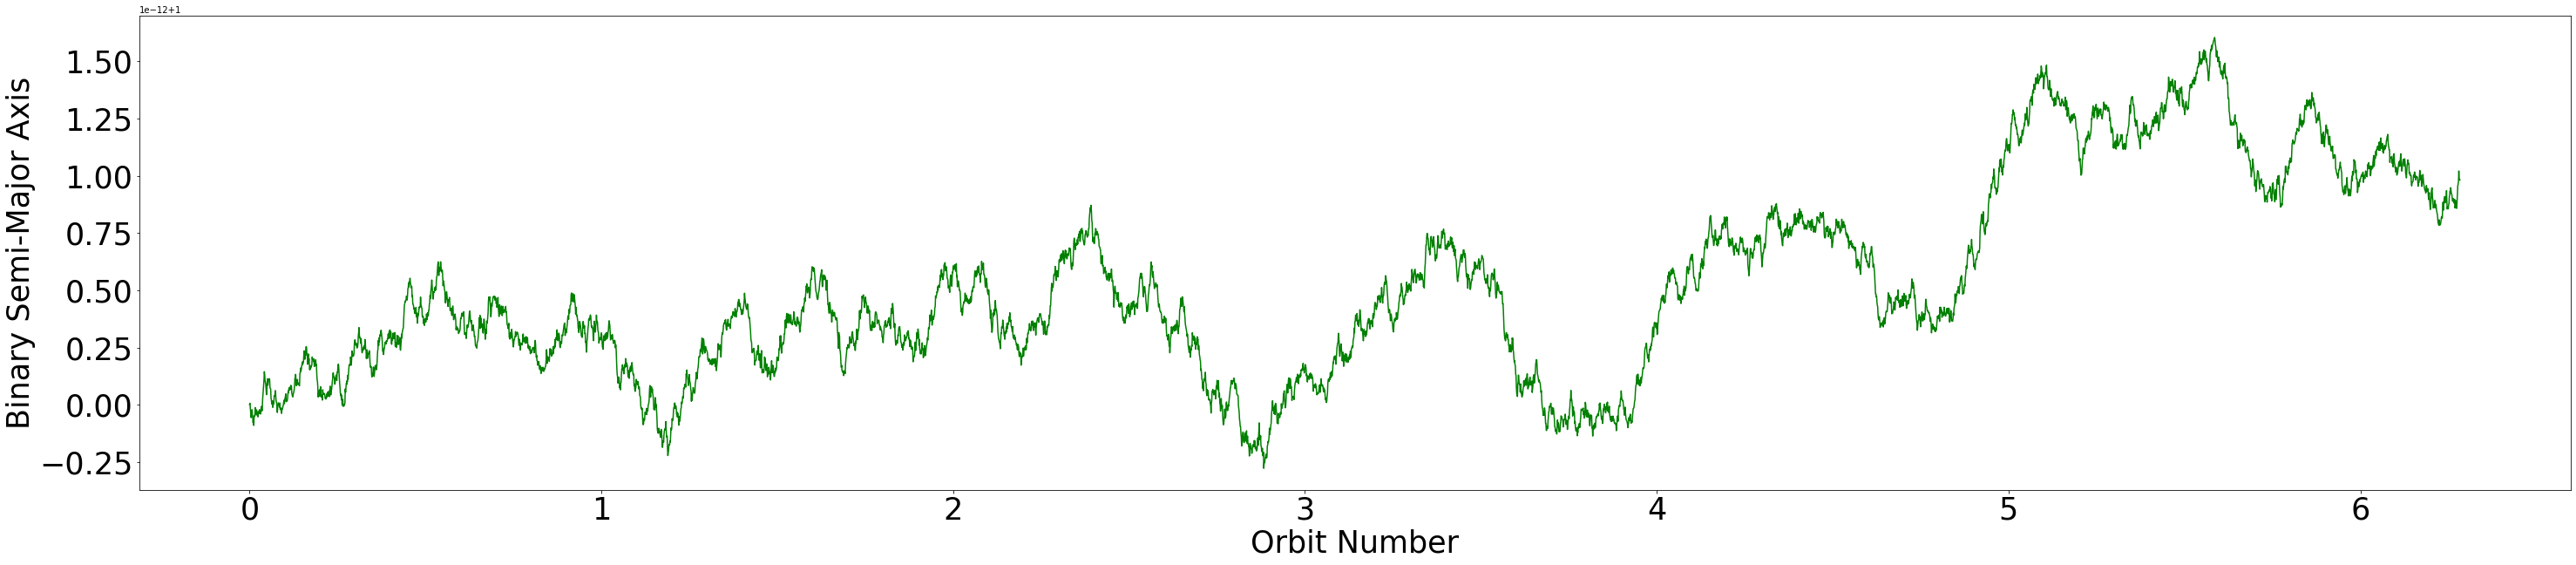

In [197]:
binary_semi("KCeb0.583_ap5.000_Np5.0_tup7.0_tau0.0030.bin")

In [46]:
# Functions to Plot Orbital evolution of Individual Planets

def orbit(archive):
    sim_arc = rb.SimulationArchive(archive)
    
    x_arr = []
    y_arr = []
    
    for snap in range(len(sim_arc)): 
        
        for i in range(2, sim_arc[snap].N):
            base = sim_arc[snap].particles[i]
        
            orb_element = base.e
            time = sim_arc[snap].t
            
            if orb_element not in y_arr:
                y_arr.append(orb_element)
            #if time not in x_arr:
                x_arr.append(time)
    
    fig = plt.figure(figsize=(50,20))
    plt.xlabel("Simulation Time", fontsize=35)
    plt.ylabel("Eccentricity", fontsize=35)
    plt.xticks(fontsize= 35)
    plt.yticks(fontsize= 35)
    #plt.plot(x_arr,y_arr)
    plt.scatter(x_arr,y_arr, color='teal') #, marker=",") #s=2

In [65]:
#orbit('KCeb0.350_ap2.333_Np5.0_tup7.0_tau0.0030.bin')